# Предсказание атрибутов узлов с использованием графовых нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Курс "Машинное обучение на графах", Лекции 4-5 "Графовые нейронные сети"
* Документация:
    * https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
    * https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html
    * https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers

## Вопросы для совместного обсуждения

1\. Обсудите основные шаги для решения задачи предсказания атрибутов узлов при помощи графовых нейронных сетей c использованием пакета `torch_geometric`.

In [2]:
from torch_geometric.datasets import Planetoid

In [3]:
dataset = Planetoid(name="Cora", root="data/torch")

In [4]:
g = dataset[0]
g

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
g.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [6]:
import torch_geometric.nn as gnn
import torch

In [7]:
layer = gnn.GraphConv(1433, 10)
h1 = layer(g.x, g.edge_index)
h1.shape

torch.Size([2708, 10])

In [8]:
out_train = h1[g.train_mask]
y_train = g.y[g.train_mask]

## Задачи для самостоятельного решения

In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from sklearn.manifold import TSNE
import torch as th
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

<p class="task" id="1"></p>

1\. Загрузите граф `Planetoid/Cora` из `torch_geometric.datasets`.

Выведите на экран:
- количество узлов графа;
- количество ребер графа;
- размерность признаков узлов;
- количество узлов для обучения, валидации и тестирования.

Решите задачу классификации узлов графа, используя только полносвязные слои `torch.nn.Linear` (создайте модель из двух слоев). Для обучения используйте пакетный градиентный спуск (не разбивайте на батчи). Обратите внимание, что настройка весов модели должна проводиться только на основе примеров из обучающей выборки. Посчитайте и выведите на экран значение `accuracy` на тестовой выборке.

- [x] Проверено на семинаре

In [2]:
dataset = Planetoid(name='Cora', root='data/torch')
data = dataset[0]
data.num_nodes, data.num_edges, dataset.num_node_features, dataset.num_classes

(2708, 10556, 1433, 7)

In [3]:
data.train_mask.sum(), data.val_mask.sum(), data.test_mask.sum()

(tensor(140), tensor(500), tensor(1000))

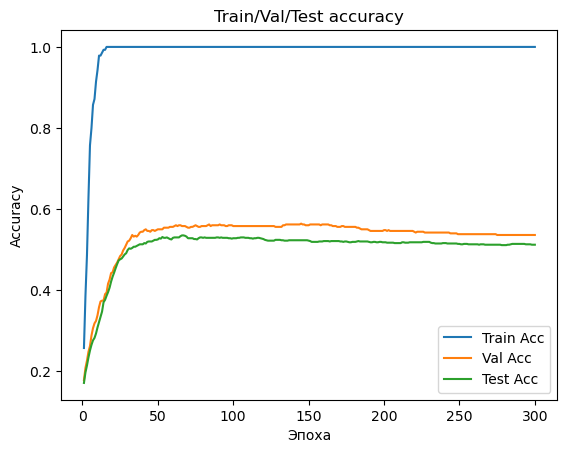

In [12]:
class LinMLP(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = th.nn.Linear(in_channels, hidden_channels)
        self.lin2 = th.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

model = LinMLP(in_channels=dataset.num_node_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = th.optim.AdamW(model.parameters(), lr=0.001)
criterion = th.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with th.no_grad():
        out = model(data.x)
        pred = out.argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        return correct / int(mask.sum())

epochs = 300
train_accs = []
val_accs = []
test_accs = []

model.train()
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    test_acc = evaluate(data.test_mask)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)


plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, epochs+1), val_accs, label='Val Acc')
plt.plot(range(1, epochs+1), test_accs, label='Test Acc')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Train/Val/Test accuracy')
plt.legend()
plt.show()

<p class="task" id="2"></p>

2\. Решите задачу 1, используя два слоя `torch_geometric.nn.GCNConv` вместо полносвязных слоев `torch.nn.Linear`.

- [x] Проверено на семинаре

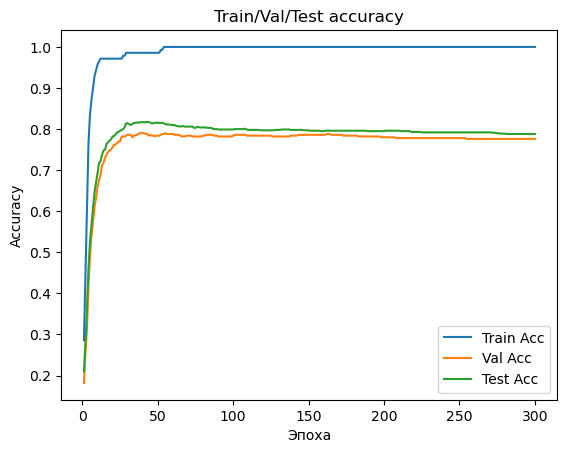

In [13]:
class GNN(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
)
optimizer = th.optim.AdamW(model.parameters(), lr=0.001)
criterion = th.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with th.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        return correct / int(mask.sum())

epochs = 300
train_accs = []
val_accs = []
test_accs = []

model.train()
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_accs.append(evaluate(data.train_mask))
    val_accs.append(evaluate(data.val_mask))
    test_accs.append(evaluate(data.test_mask))

plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, epochs+1), val_accs,   label='Val Acc')
plt.plot(range(1, epochs+1), test_accs,  label='Test Acc')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Train/Val/Test accuracy')
plt.legend()
plt.show()

<p class="task" id="3"></p>

3\. Воспользовавшись необученной моделью из предыдущего задания, получите прогнозы для всех узлов графа. Уменьшите размерность полученных прогнозов до 2 при помощи алгоритма t-SNE (`sklearn.manifold.TSNE`). Визуализируйте точки на плоскости, используя полученные значения в качестве координат. Раскрасьте точки в цвета, соответствующим меткам узлов.

Повторите данную процедуру, используя обученную модель. Сравните результаты и сделайте выводы.

- [x] Проверено на семинаре

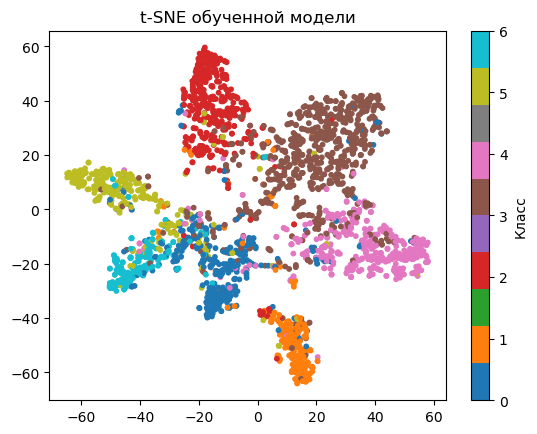

In [ ]:
model.eval()
with th.no_grad():
    logits = model(data.x, data.edge_index)  
    
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings = tsne.fit_transform(logits.cpu().numpy())

scatter = plt.scatter(embeddings[:,0], embeddings[:,1], c=data.y.cpu().numpy(), cmap='tab10', s=10)
plt.title('t-SNE обученной модели')
plt.colorbar(scatter, label='Класс')
plt.show()
model = GNN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
)

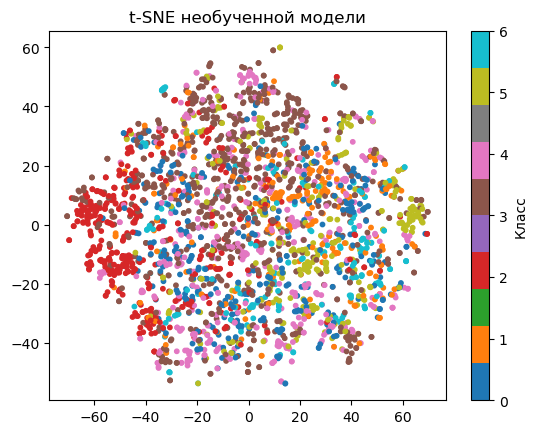

In [ ]:
model.eval()
with th.no_grad():
    logits = model(data.x, data.edge_index)

tsne_trained = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings = tsne_trained.fit_transform(logits.cpu().numpy())

scatter = plt.scatter(embeddings[:,0], embeddings[:,1], c=data.y.cpu().numpy(), cmap='tab10', s=10)
plt.title('t-SNE необученной модели')
plt.colorbar(scatter, label='Класс')
plt.show()

<p class="task" id="4"></p>

4\.  Предыдущие решения не используют узлы, находящиеся в валидационном множестве. Решите задачу 2, используя валидационное множество для выполнения ранней остановки.

- [x] Проверено на семинаре

Ранняя остановка на эпохе 90


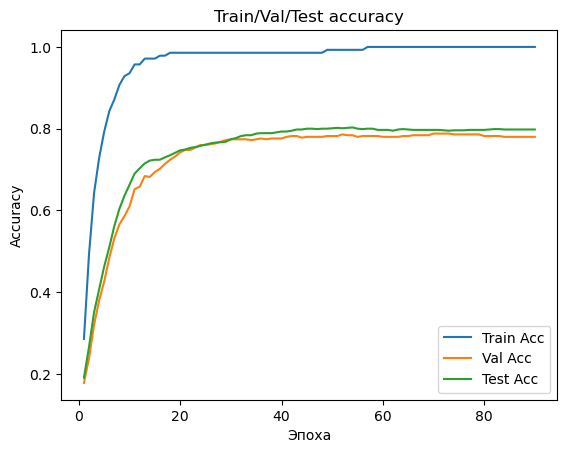

In [18]:
class GNN(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
)
optimizer = th.optim.AdamW(model.parameters(), lr=0.001)
criterion = th.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with th.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        return correct / int(mask.sum())

epochs = 300
train_accs = []
val_accs = []
test_accs = []
best_val_acc = 0.0
patience = 20  
patience_counter = 0

model.train()
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    test_acc = evaluate(data.test_mask)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        break

plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1, len(val_accs)+1), val_accs,   label='Val Acc')
plt.plot(range(1, len(test_accs)+1), test_accs,  label='Test Acc')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Train/Val/Test accuracy')
plt.legend()
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, сравнив несколько различных слоев:
* GCNConv
* SAGEConv (укажите `aggr="mean"`)
* GATConv (выберите для первого слоя `heads > 1`)

Выведите результат в виде таблицы:

| Модель    | Loss на обучении | Acc на обучении | Acc на тесте | Кол-во эпох до ранней остановки |
|-----------|------------------|-----------------|--------------|-------------|
| GraphConv |                  |                 |              |             |
| SAGEConv  |                  |                 |              |             |
| GATConv   |                  |                 |              |             |


- [x] Проверено на семинаре

In [4]:
class GNN(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
)
optimizer = th.optim.AdamW(model.parameters(), lr=0.001)
criterion = th.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with th.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        return correct / int(mask.sum())

epochs = 300
train_accs = []
val_accs = []
test_accs = []
best_val_acc_1 = 0.0
patience = 20  
patience_counter = 0

model.train()
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    test_acc = evaluate(data.test_mask)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if val_acc > best_val_acc_1:
        best_val_acc_1 = val_acc
        best_train_acc_1 = train_acc
        best_test_acc_1 = test_acc
        best_loss_1 = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        epochs_1 = epoch
        break

Ранняя остановка на эпохе 112


In [5]:
class GNN(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr="mean")
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr="mean")

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

model = GNN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
)
optimizer = th.optim.AdamW(model.parameters(), lr=0.001)
criterion = th.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with th.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        return correct / int(mask.sum())

epochs = 300
train_accs = []
val_accs = []
test_accs = []
best_val_acc_2 = 0.0
patience = 20  
patience_counter = 0

model.train()
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    test_acc = evaluate(data.test_mask)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if val_acc > best_val_acc_2:
        best_val_acc_2 = val_acc
        best_train_acc_2 = train_acc
        best_test_acc_2 = test_acc
        best_loss_2 = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        epochs_2 = epoch
        break

Ранняя остановка на эпохе 52


In [ ]:
class GNN(th.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)  
        self.conv2 = GATConv(hidden_channels*4, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


model = GNN(
    in_channels=dataset.num_node_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
)
optimizer = th.optim.AdamW(model.parameters(), lr=0.001)
criterion = th.nn.CrossEntropyLoss()

def evaluate(mask):
    model.eval()
    with th.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = pred[mask].eq(data.y[mask]).sum().item()
        return correct / int(mask.sum())

epochs = 300
train_accs = []
val_accs = []
test_accs = []
best_val_acc_3 = 0.0
patience = 20  
patience_counter = 0

model.train()
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    test_acc = evaluate(data.test_mask)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    if val_acc > best_val_acc_3:
        best_val_acc_3 = val_acc
        best_train_acc_3 = train_acc
        best_test_acc_3 = test_acc
        best_loss_3 = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        epochs_3 = epoch
        break

Ранняя остановка на эпохе 42


In [10]:
results = [
    ['GCNConv',  best_loss_1, best_train_acc_1, best_test_acc_1, epochs_1],
    ['SAGEConv', best_loss_2, best_train_acc_2, best_test_acc_2, epochs_2],
    ['GATConv',  best_loss_3, best_train_acc_3, best_test_acc_3, epochs_3]
]

df = pd.DataFrame(results, columns=['Модель', 'Loss на обучении', 'Acc на обучении', 'Acc на тесте', 'Кол-во эпох до ранней остановки']).sort_values(by='Acc на тесте', ascending=False)
df

,Модель,Loss на обучении,Acc на обучении,Acc на тесте,Кол-во эпох до ранней остановки
0,GCNConv,0.096089,1.000000,0.791,112
2,GATConv,0.473992,0.985714,0.787,42
1,SAGEConv,0.252370,1.000000,0.772,52
